# **FMNIST Multiclass Classification using a variation of the SimpleResnet Model**

# **Setup environment**

In [25]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
custom_function_folder = base_folder/'custom_functions'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'HW6_FMNIST/Models'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'HW6_FMNIST/FMNIST_Project/'
sys.path.append(str(project_folder))

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/custom_functions',
 '/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/FMNIST_Project']

In [ ]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_fmnist import FashionMNISTDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

In [ ]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=120):
        super(SimpleResNet, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResidualBlock(16, 16, stride=2),
            ResidualBlock(16, 64, stride=2),
            #ResidualBlock(32, 128, stride=2),
            ResidualBlock(64, 256, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=120)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 840328
Trainable parameters: 840328


# **Function to load the model**

In [ ]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(model_config['num_classes'])
    return model


# **Functions for Transformations**

In [ ]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

# **Function to load DataModule**

In [ ]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = FashionMNISTDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# **Function to load LightningModule**

In [ ]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

# **Function to load the Trainer**

In [ ]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

# **Function to load components**

In [ ]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [ ]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# **Function to Load config files**

In [ ]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

# **Function to free memory**

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# **Run One training and validation batch to check bugs**

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 812 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccura

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.09 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.34, Train_Metric: 0.08


# **Find Learning Rate**

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.10 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.004641588833612778
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_907f1ae7-4834-452c-b629-d57d328b609e.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_907f1ae7-4834-452c-b629-d57d328b609e.ckpt


Train_Loss: 2.52, Train_Metric: 0.29
0.004641588833612778


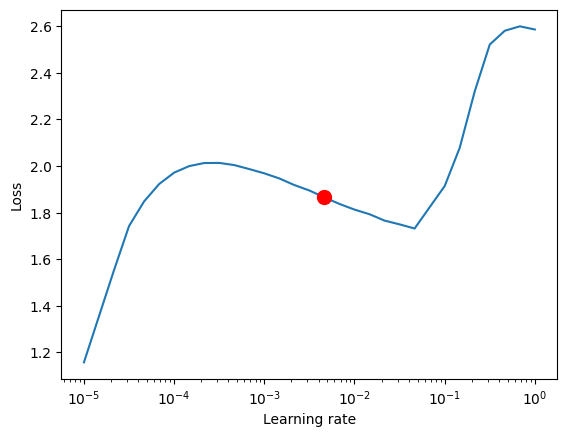

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

# **Overfit Small Subset**

In [ ]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.005
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 812 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.09 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.12 | Train_Loss: 2.32, Train_Metric: 0.05


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.29, Val_Metric: 0.12 | Train_Loss: 2.03, Train_Metric: 0.27


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.38, Val_Metric: 0.12 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Train_Loss: 1.85, Train_Metric: 0.33


# **Model Training using variation of Resnet**

- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 100% of train/val data
- max epochs = 10 (as given in the hw question)
- number of parameters in the model = 840328 (didn't exceed 1 milion)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the ba

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 6.43, Val_Metric: 0.10 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved. New best score: 0.100


Train_Loss: 0.67, Train_Metric: 0.76


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.61, Val_Metric: 0.79 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.691 >= min_delta = 0.0. New best score: 0.791


Train_Loss: 0.38, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.36, Val_Metric: 0.87 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.075 >= min_delta = 0.0. New best score: 0.867


Train_Loss: 0.32, Train_Metric: 0.89


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.30, Val_Metric: 0.89 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.025 >= min_delta = 0.0. New best score: 0.891


Train_Loss: 0.29, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.27, Train_Metric: 0.91
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.29, Val_Metric: 0.90 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.896


Train_Loss: 0.22, Train_Metric: 0.92


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.29, Val_Metric: 0.89 | Train_Loss: 0.21, Train_Metric: 0.93
Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.016 >= min_delta = 0.0. New best score: 0.912


Train_Loss: 0.16, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.25, Val_Metric: 0.92 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.915


Train_Loss: 0.15, Train_Metric: 0.95
Epoch 00009: reducing learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.21, Val_Metric: 0.92 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.008 >= min_delta = 0.0. New best score: 0.924


Train_Loss: 0.11, Train_Metric: 0.96


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


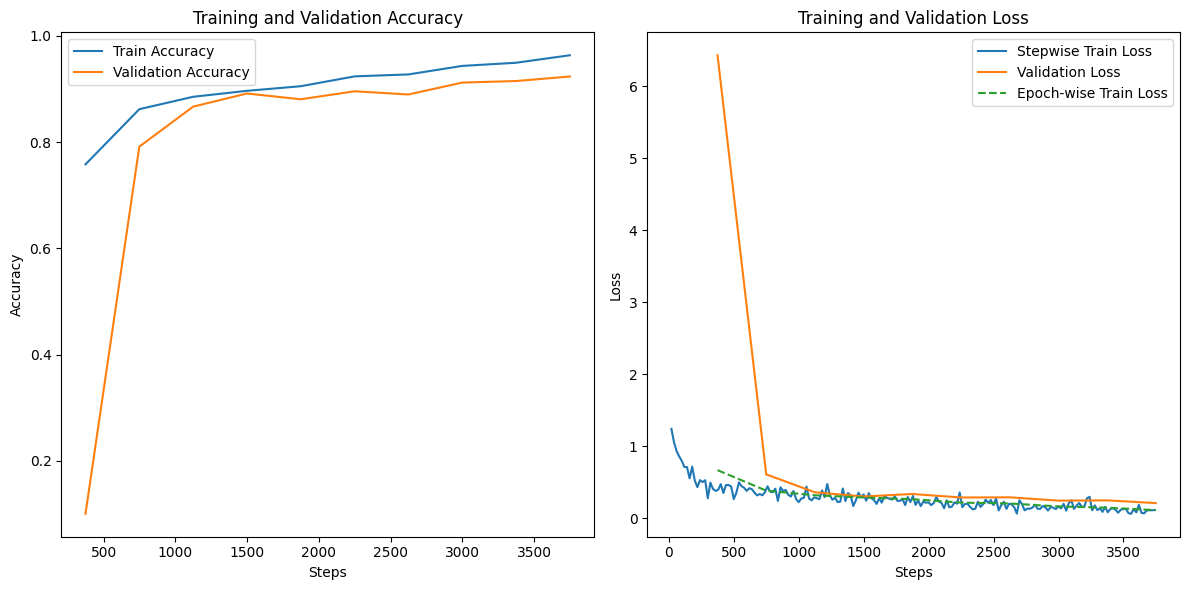

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/Models/logs/epoch=9-step=3750-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/Models/logs/epoch=9-step=3750-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.09, Val_Metric: 0.97 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/Models/logs/epoch=9-step=3750-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/Models/logs/epoch=9-step=3750-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.21, Val_Metric: 0.92 | Train Accuracy: 97.45
Validation Accuracy: 92.35


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
lr-AdamW,████▄▄▂▂▂▁▁█████▄▄▂▂▁
train_loss_epoch,█▄▄▃▂▂▂▂▁▁█▄▄▃▃▂▂▂▁▁
train_loss_step,█▅▅▄▄▄▃▂▂▂▃▂▂▂▂▂▁▂▁▁▁▅▅▄▄▄▃▂▃▂▃▂▂▃▂▂▂▂▁▁
train_metric,▁▅▅▆▆▇▇▇▇█▁▅▅▆▆▇▇▇██
trainer/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇█
val_loss,▄▂▁▃▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁
val_metric,▃▆▇▅▇▇▇█▇██▁▇▇▇▇▇▇█████
epoch,10
lr-AdamW,0.00063
train_loss_epoch,0.11322


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.005
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'min', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='FMNIST_multiclass_CNN'
cl_config['wandb']['name']='resnet_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=128
# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# **Conclusion:**

**Achieved a validation accuracy of 92.35% by training the model for 10 epochs on whole training dataset(80% Train and 20% Valid) of FMNIST as we can see in the Run summary above**

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [27]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/PoojaAkkaladevi_HW6.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/PoojaAkkaladevi_HW6.ipynb to pdf
[NbConvertApp] Support files will be in PoojaAkkaladevi_HW6_files/
[NbConvertApp] Making directory ./PoojaAkkaladevi_HW6_files
[NbConvertApp] Making directory ./PoojaAkkaladevi_HW6_files
[NbConvertApp] Writing 87177 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 160591 bytes to /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW6_FMNIST/PoojaAkkaladevi_HW6.pdf
